Anritsu Time domain Measurement Analysis
======================


**Measurement configuration**

Anritsu Shockline Vector network analyser
* Output power 5 dBm ?
* Fmax = 8.0 GHz
* 10001 points
* Low pass time domain frequency spacing.
* Add 50us delay to sweep to accommodate the additional electrical length
* IF Bandwidth 10kHz

Connected to GPS cable




Functions to load and process VNA data, find the range
---------------------------
Run this first to set up the functions

In [97]:
%pylab inline
import os
import numpy as np


def loadfile(filename):
    # loads a CSV file, returns frequency and complex reflection coefficient
    try:
        temp=np.genfromtxt(filename,skip_header=3,delimiter=',')
        return temp[:,0],temp[:,1]+1j*temp[:,2]
    except:
        print 'Error - could not load file %s' % filename
    #print 'loaded %i rows from %s' % (shape(temp)[0],filename)

def loadfile_multisweep(filename):
    #Added in V0.b. Recorded files with multiple sweeps in it
    try:
        temp=np.genfromtxt(filename,delimiter=',')
        data_matrix = []
        for i in temp:
            data_matrix.append(i[::2]+1j*i[1::2])
        return data_matrix
    except:
        print 'Error - could not load file %s' % filename
    #print 'loaded %i rows from %s' % (shape(temp)[0],filename)
        
def loadfile_frequency(filename):    
    #Added in V0.b. For frequency file
    try:
        return np.genfromtxt(filename,delimiter=',')
    except:
        print 'Error - could not load file %s' % filename
    #print 'loaded %i rows from %s' % (shape(temp)[0],filename)
    
def loadfile_frequency2(filename):
    #Added in V0.b. Loads a CSV file with frequencies which is extracted from a export from the ZVB (i.e. not the logging program)
    try:
        temp=np.genfromtxt(filename,skip_header=3,delimiter='\t')
        return temp[:,0]
    except:
        print 'Error - could not load file %s' % filename
    #print 'loaded %i rows from %s' % (shape(temp)[0],filename)

def loadtrace_anritsu(vna_stream):
    vna.send('INIT:IMM;*WAI\n')
    vna.send(':CALC:TDATA:SDAT?\n')
    temp_char = vna.recv(1000000000)
    
    freq = []
    real = []
    imag = []
    sdata = []
    for i in temp_char.split('\n')[13:-3]:
        freq.append(float(i.split(">")[1].split('<')[0].split(';')[0]))
        x = float(i.split(">")[1].split('<')[0].split(';')[1])
        y = float(i.split(">")[1].split('<')[0].split(';')[2])
        sdata.append(x + 1j*y)
        
    print len(freq), len(sdata)
    
    return np.array(freq),np.array(sdata)
    

    
def plotresponse(F,S):
    # plots the magnitude and phase of the response
    figure(figsize=(14,2))
    plot(F/1e9,20*log10(abs(S)))
    grid(True); xlabel('Frequency, GHz'); ylabel('Response, dB'); title('Response magnitude plot')
    figure(figsize=(14,2))
    plot(F/1e9,180*unwrap(angle(S))/pi/1e3)
    grid(True); xlabel('Frequency, GHz'); ylabel('Unwrapped phase, Kdegrees'); title('Response phase plot')

    
    
def simulatefile(snr=60,fmax=8e9,pts=10001,signals = [[1,10.0]]):
    # simulatefile(snr=60, fmax=8e9, pts=10001,overs=10,signals = [[1,10.0]])
    # snr  in dB signal to noise, per-bin. Use >99 for no noise
    # fmax in Hz
    # pts = VNA frequency points
    # signals - list of lists, [[Voltage,Xpos],[...]]
    # returns vectors of F (freq Hz) and S (response)

    # First make frequency vector
    F=np.linspace(0,fmax,pts,endpoint=True);
    
    # initialise the complex response vector and fill with (complex) noise
    R=np.zeros(shape(F)[0]);
    if snr<99:
        R = R + np.random.randn(shape(F)[0])*exp(1.0j*np.random.random(shape(F)[0])*2*pi)*10**(-snr/20)*np.sqrt(pts);
    
    # add each of the signals
    c = 299792458
    for a in signals:
        R = R + a[0]*exp(-1.0j*2*pi*a[1]*F/c);

    # to do - phase noise on the signals
    # to do - frequency quantisation - if applicable. The VNA must have a minimum frequency step?
    # to do - non-flat passband modelling
    # to do - fibre optic time-domain effects if any
    
    return F,R



def transform(F,S,verbose=0,overs=0,window=False):
    # transforms f,s into time domain, returns time of peak
    # overs times frequency extension for oversampling
    # window True will apply a hanning window to the frequency data
    # verbose:  0=no printing, just return range   1=print summary  2=close-up graphs  3=full graph + close-up
    # Improved on 13 Oct 2016 - when oversampling, rounds off to the nearest power of two
    # Assume F is in GHz
    
    F = F*1e9
    pts = shape(F)[0]
    c = 299792458
    fmax=F[-1]+(F[2]-F[1]) # fmax is one more than the last frequency in the file
    
    # add the DC value
    if F[0]>0:
        pts = pts + 1;
        S = np.insert(S,0,0)
        if verbose>2: print 'Transform: adding a DC value to the file'
    
    # apply a window
    if window:
        w=hanning(pts*2); w=w[pts:];  w=w/mean(w);
        S = S * w;
        if verbose>2: print 'Transform: applying Hanning window'

    # IFFT without oversampling
    T = np.fft.ifft(S);
    X = np.linspace(0,c/F[0],pts,endpoint=False);
        
    # Oversample by extending frequency axis and IFFT again
    if overs>0:
        newtotallength=int(2**np.floor(np.log(overs*pts)/np.log(2)))
        #print 'Oversampling. You requested %i, you get %i x (rounding to power of two)' % (overs,int(newtotallength/pts))
        FO=np.linspace(fmax/pts,fmax*overs,newtotallength,endpoint=True);  # changed endpoint from True
        SO = np.pad(S,(0,newtotallength-pts),'constant')
        TO = np.fft.ifft(SO)*(newtotallength*1.0/pts);
        XO = np.linspace(0,c/F[0],newtotallength,endpoint=False);
    else:
        TO = T;
        XO = X;

        
    # find the peak
    peakindex = abs(TO).argmax()
    Xpeak=XO[peakindex]
    Tpeak=np.abs(TO[peakindex])
    peakrange = slice(peakindex-5*overs,peakindex+5*overs)   # speed up the graph
    
    # plot if requested
    if verbose>2:
        # plot - wide
        figure(figsize=(14,6))
        plot(X,20*log10(np.abs(T)),'b-',marker='o',ms=4,lw=1)
        ylim([-120,1]);  grid(True);   # xlim([0,100]); 
        ylabel('response, dB');  xlabel('distance, m');  title('Full unambiguous range, first copy')

    if verbose>1:
        # plot - narrow
        matplotlib.rcParams.update({'font.size': 18})
        figure(figsize=(15,8))
        plot(X,20*log10(np.abs(T)),'k--',marker='.',ms=16,lw=2,label='normal sampling')
        if overs>0:
            plot(XO[peakrange],20*log10(np.abs(TO[peakrange])),'k-',lw=2,label='%i x oversampling' % overs)
            plot(Xpeak,20*log10(Tpeak),marker='+',ms=20,color='k',label='detected peak position')
        xlim([Xpeak-0.02,Xpeak+0.02]);
        ylim([np.around(20*log10(Tpeak)-35,decimals=-1),np.around(20*log10(Tpeak)+5,decimals=0)]);
        grid(True); legend(loc=0);
        ylabel('response, dB');  xlabel('distance, m');
        #title('Peak at %8.5f m' % Xpeak)

    if verbose>0: print 'Fmax=%4.1f GHz. %i points, %ix oversampled. Window=%i. Peak found at %8.5f m' % ((fmax)/1e9, pts, overs, window, Xpeak)

    return Xpeak


Populating the interactive namespace from numpy and matplotlib


In [79]:
import socket, time, datetime, array

vna = socket.socket(socket.AF_INET, socket.SOCK_STREAM);  vna.setblocking(0); 
vna.settimeout(2.0) #this was increased to 2 seconds when downloading 10000 x,y points from ZVB
vna.connect(('192.168.4.136', 5001));  # Anritsu Shockline Vector Network Analyser
vna.send('INIT1:CONT OFF\n')

# check that connection has been made successfully
vna.send('*IDN?\n');  time.sleep(1);  reply=vna.recv(100); reply=reply[:-2];  print('Ident     : %s' % reply)

Ident     : ANRITSU,MS46322A,1627002,V2.2.02,V2.1.8


In [14]:
#run at end of measurement
vna.close()

In [104]:
#save data to file
numpy.savetxt('2016-10-27-S11-freq-data',freq)
numpy.savetxt('2016-10-27-S11-complex-data',sdata,fmt='%5.10f')

Transform: adding a DC value to the file
Fmax= 8.0 GHz. 10002 points, 50x oversampled. Window=0. Peak found at  0.01617 m


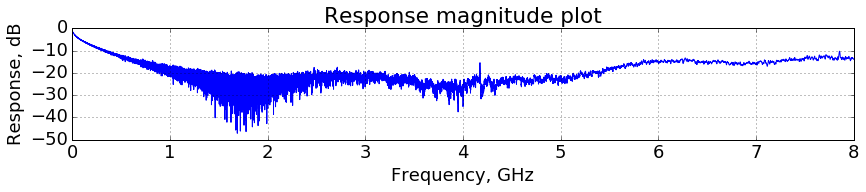

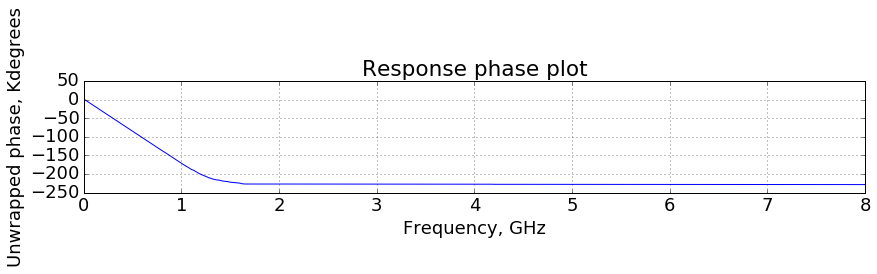

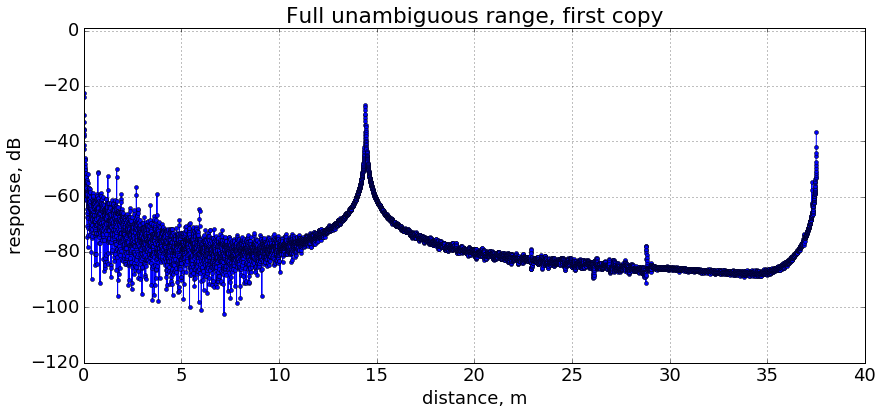

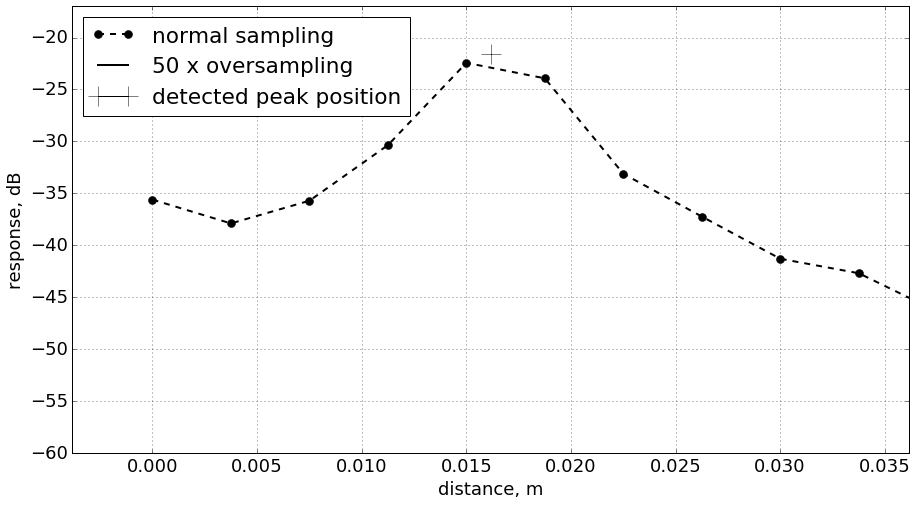

In [111]:
#freq,sdata = loadtrace_anritsu(vna)
plotresponse(freq*1e9,sdata)
transform(freq,sdata,overs=50,verbose=9);

### WITH NO OVERSAMPLING ###
Peak at 57.61194 metres

### WITH 100 TIMES OVERSAMPLING ###
First peak = 0.06983 metres
Second peak = 57.46470 metres


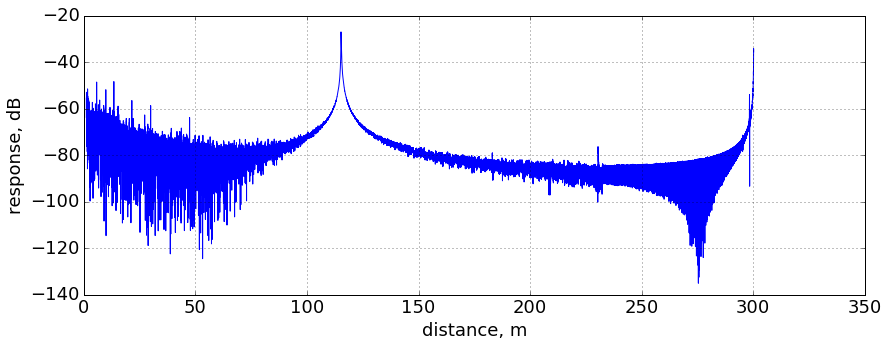

In [186]:
#sdata is the complex S11 data
#freq is the frequency and is in GHz
#Assume 80% propagation delay in coax

c = 299792458
pts = len(sdata)
F = freq*1e9 #convert to GHz to Hz
fmax = max(freq)*1e9

#No oversampling
T0 = np.fft.ifft(sdata)
X0 = np.linspace(0,c*0.8/(F[1]-F[0]),pts,endpoint=False)
#plot(X,20*log10(abs(T)))
print "### WITH NO OVERSAMPLING ###"
print "Peak at %0.5f metres\n" % (X0[T0.argmax()]/2)

#With Oversampling
overs = 100
newtotallength=int(2**np.floor(np.log(overs*pts)/np.log(2)))
FO=np.linspace(fmax/pts,fmax*overs,newtotallength,endpoint=True);  # changed endpoint from True
S = np.pad(sdata,(0,newtotallength-pts),'constant')
T = np.fft.ifft(S)*(newtotallength*1.0/pts);
X = np.linspace(0,c*0.8/(F[1]-F[0]),newtotallength,endpoint=False)

figure(figsize=(14,5))
plot(X[2000:],20*log10(abs(T)[2000:]))
ylabel('response, dB');  xlabel('distance, m'); grid(True)

print "### WITH 100 TIMES OVERSAMPLING ###"
print "First peak = %3.5f metres" % (X[T.argmax()]/2)
print "Second peak = %3.5f metres" % (X[T[500:].argmax()]/2)

#temp_peaks = np.sort(abs(T))[::-1]
#for i in range(10):
#    print abs(temp_peaks[i])


Load and plot one file
----------------

In [ ]:
F = loadfile_frequency('vna_files/data2/frequency.txt')
S_list = loadfile_multisweep('vna_files/data2/1468943239.14.txt')

plotresponse(F,S_list[0])
transform(F,S_list[0],overs=50,verbose=9);

#Now checking the sweep-sweep variation for the 10 sweeps in one file

#for n,sweep in enumerate(S_list):
#    Xpeak = transform(F,sweep,overs=100);
#    if n==0:
#        Xfirstpeak=Xpeak
#    print 'peak at %8.5f m, delta of %+6.3f mm' % (Xpeak,(Xpeak-Xfirstpeak)*1000)

**Determining peak over time**

In [ ]:
float(files[0].lstrip('vna_files/data2/').rstrip('.txt')),float(files[1].lstrip('vna_files/data2/').rstrip('.txt')),float(files[2].lstrip('vna_files/data2/').rstrip('.txt'))

Load all the patchlead files
------------------------------

In [ ]:
import glob
import time

starttime = time.time()

files = glob.glob('vna_files/data2/*.txt')
files.sort(key=os.path.getctime)
files.remove('vna_files/data2/frequency.txt')

F = loadfile_frequency('vna_files/data2/frequency.txt')

#array storing delta length changes and time_stamps for files in directory
delta_length = np.empty(0)
timestamps = np.empty(0)

#Enumerate through each files and solve for the reference delay and store into delta_length
#Only taking the first sweep in the file

for n,fname in enumerate(files[::2]):
    S = loadfile_multisweep(fname)[0]
    Xpeak = transform(F,S,overs=1678);
    if n==0:
        Xfirstpeak=Xpeak
    delta_length = np.append(delta_length,(Xpeak-Xfirstpeak)*1000)
    timestamps = np.append(timestamps,float(fname.lstrip('vna_files/data2/').rstrip('.txt')))
    print 'peak at %8.5f m, delta of %+6.5f mm for sweep file %4.0f/%4.0f' % (Xpeak,(Xpeak-Xfirstpeak)*1000,n,len(files))

print 'Total time = %f minutes' % ((time.time()-starttime)/60)

In [ ]:
# plot for the report
tshours = timestamps/3600.0 - timestamps[0]/3600.0          # convert seconds to hours, normalise
#tshours = np.array(timestamps)/3600.0 - floor(timestamps[0]/86400.0)*24 + 2         # convert seconds to SAST Hours
delta_fs = delta_length / 1e3 / 299792458 * 1e15            # convert mm to fs

matplotlib.rcParams.update({'font.size': 18})
figure(num=None, figsize=(15, 8),frameon=False)
plot(tshours,delta_fs,lw=2,ms=0,marker='.',color='k')
xticks(range(0,18,6))
xlabel('Time after start, hours')
ylabel('Change from start, Femtoseconds')
title('Time drift of a 2 m patch-lead');

In [ ]:
# plot for the report - old version with broken Transform!!!!!
tshours = timestamps/3600.0 - timestamps[0]/3600.0          # convert seconds to hours, normalise
#tshours = np.array(timestamps)/3600.0 - floor(timestamps[0]/86400.0)*24 + 2         # convert seconds to SAST Hours
delta_fs = delta_length / 1e3 / 299792458 * 1e15            # convert mm to fs

matplotlib.rcParams.update({'font.size': 18})
figure(num=None, figsize=(15, 8),frameon=False)
plot(tshours,delta_fs,lw=2,ms=0,marker='.',color='k')
xticks(range(0,18,6))
xlabel('Time after start, hours')
ylabel('Change from start, Femtoseconds')
title('Time drift of a 2 m patch-lead');

** older plotter **

In [ ]:
#Conver timestamp gathered from files to Date-Time object for plotting

from datetime import datetime, date, time

#Array to hold datetime timestamps
timestamps_datetime = []

for seconds in timestamps:
    timestamps_datetime.append(datetime.fromtimestamp(seconds))   
    


In [ ]:
# plot for the report
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=120))
plt.plot(date2num(timestamps_datetime),delta_length)
plt.gcf().autofmt_xdate()
plt.grid()
plt.title('Length changes (mm) over 12 hours')

In [ ]:
import sys
import cPickle as pickle
import zlib

#TO WRITE
with open('./vna_files/data2/'+'data2.gz', 'wb') as f:
    f.write(zlib.compress(pickle.dumps([F,timestamps,delta_length], pickle.HIGHEST_PROTOCOL),9))

In [ ]:
F[1868]

In [ ]:
#Check S21 at a single frequency over time to further validate the raw data
#One would expect a drift over time

S21_dB = []

for fname in files:
    S = loadfile_multisweep(fname)[0]
    S21_dB.append(20*log10(abs(S[1868])))

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=120))
plt.plot(date2num(timestamps_datetime),S21_dB)
plt.gcf().autofmt_xdate()
plt.grid()
plt.title('S21_dB @ %4.0f MHz over 12 hours' % (F[1868]/1e6) ) 

In [30]:
max(F)

NameError: name 'F' is not defined

Quick investigation of impact of reflections on Phase
-----------

In [ ]:
# using complex numbers as vectors

freq=6.0e9                   # using an 6 GHz measurement frequency

refmag = 10.0**(   -40   /20.0)    # how many dB down?
refang = 90 * pi/180.0

sig = complex(1,0)
ref = complex(refmag*np.cos(refang),refmag*np.sin(refang))

deltat = (angle(ref+sig)-angle(sig))/(2*pi)/freq * 1.0e12


print 'phase of sig = %f degrees, phase of both = %f degrees' % (np.angle(sig)*180/pi,np.angle(sig+ref)*180/pi)
print 'time error using an 8 GHz signal is %f ps' % deltat